## Autoencoder

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Load the dataset

In [121]:
train_path = '/kaggle/input/indian-birds/Birds_25/train'
valid_path = '/kaggle/input/indian-birds/Birds_25/valid'

In [123]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
LATENT_DIM = 128
KERNEL_SIZE = 3

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = train_path, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    shuffle = False,
    batch_size = BATCH_SIZE 
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = valid_path,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    shuffle = False,
    batch_size = BATCH_SIZE
)

Found 30000 files belonging to 25 classes.
Found 7500 files belonging to 25 classes.


## Replacing labels with images

In [124]:
train_dataset = train_dataset.map(lambda x, y:(x, x))
validation_dataset = validation_dataset.map(lambda x, y:(x, x))

## Normalize the dataset

In [125]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, image

train_dataset = train_dataset.map(normalize_image)
validation_dataset = validation_dataset.map(normalize_image)

In [126]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [127]:
for i, j in train_dataset:
    print(i.shape)
    break
i[0].shape

(32, 256, 256, 3)


TensorShape([256, 256, 3])

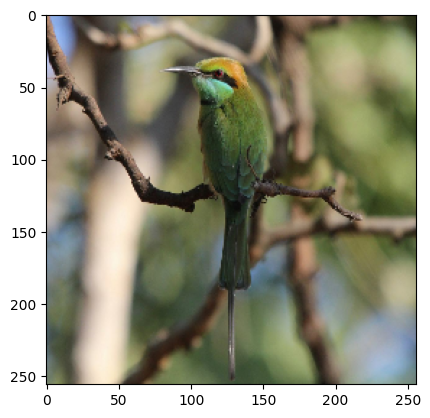

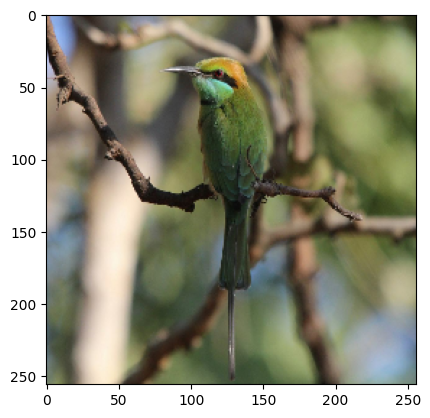

In [128]:
plt.imshow(i[1])
plt.show()

plt.imshow(j[1])
plt.show()

## Create the model

In [129]:
encoder = Sequential([
        Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3)),
        Conv2D(32, kernel_size = KERNEL_SIZE, activation = 'relu', strides = 2, padding = 'same'),
        Conv2D(64, kernel_size = KERNEL_SIZE, activation = 'relu', strides = 2, padding = 'same'),
        Conv2D(128, kernel_size = KERNEL_SIZE, activation = 'relu', strides = 2, padding = 'same'),
        Conv2D(256, kernel_size = KERNEL_SIZE, activation = 'relu', strides = 2, padding = 'same'),
        Flatten(),
        Dense(LATENT_DIM, activation = 'relu'),
    ], name = 'encoder')
encoder.summary()
    
decoder = Sequential([
        Dense(16 * 16 * 256, activation = 'relu', input_dim = LATENT_DIM),
        Reshape((16, 16, 256)),
        Conv2DTranspose(256, kernel_size = KERNEL_SIZE, activation = 'relu', strides = 2, padding = 'same'),
        Conv2DTranspose(128, kernel_size = KERNEL_SIZE, activation = 'relu', strides = 2, padding = 'same'),
        Conv2DTranspose(64, kernel_size = KERNEL_SIZE, activation = 'relu', strides = 2, padding = 'same'),
        Conv2DTranspose(32, kernel_size = KERNEL_SIZE, activation = 'relu', strides = 2, padding = 'same'),
        Conv2DTranspose(3, kernel_size = KERNEL_SIZE, activation = 'sigmoid', padding = 'same'),
    ], name = 'decoder')
decoder.summary()
    
autoencoder = Sequential([encoder, decoder], name = 'autoencoder')
autoencoder.summary()

autoencoder.compile(loss = 'mse', optimizer = 'adam')

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     8,388,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,152 (33.48 MB)

 Trainable params: 8,777,152 (33.48 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 65536)          │     8,454,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (None, 32, 32, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 64, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_33             │ (None, 256, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_34             │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,432,387 (35.98 MB)

 Trainable params: 9,432,387 (35.98 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ ?                      │     8,777,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ ?                      │     9,432,387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,209,539 (69.46 MB)

 Trainable params: 18,209,539 (69.46 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model on single batch only

In [130]:
for x_train, _ in train_dataset:
    break

In [131]:
x_train.shape

TensorShape([32, 256, 256, 3])

In [144]:
history = autoencoder.fit(x_train, x_train, epochs = 500, verbose = 0)

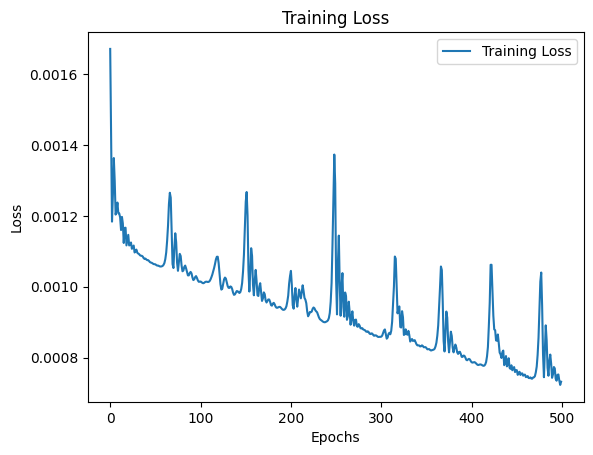

In [145]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predict the batch of image

In [146]:
decoded_images = autoencoder.predict(x_train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


## Show a few original and decoded images

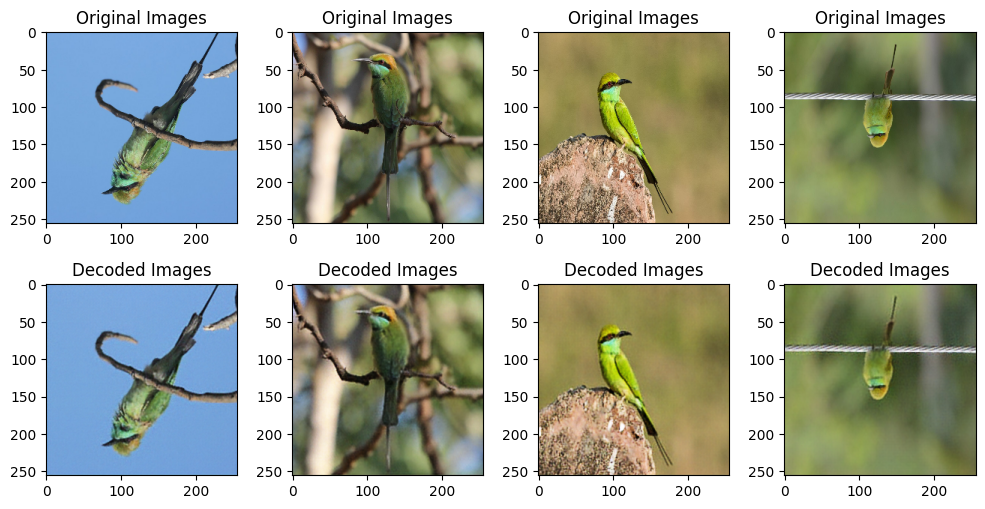

In [147]:
plt.figure(figsize = (10, 10))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i])
    plt.title('Original Images')
    
for i in range(4):
    plt.subplot(4, 4, i+5)
    plt.imshow(decoded_images[i])
    plt.title('Decoded Images')
    
plt.tight_layout()
plt.show()